# Automatic BSPF - Analysis Data Creation

Creates automatic event plots based on catalog 

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.add_radial_and_transverse_channel import __add_radial_and_transverse_channel

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __makeplot(config, st):


    st_in = st.copy()

    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6

    for i, tr in enumerate(st_in):

        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        ax[i].legend(loc=1)

    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)

    plt.show();
    del st_in
    return fig

In [4]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace

    t_ref = reference_stream[0]

    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t

    return empty

In [5]:
def __stream_to_dataframe(st):

    dff = pd.DataFrame()

    for tr in st:
        name = f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}"
        dff[name] = tr.data

    return dff

## Configurations

In [6]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
config['outpath_figs'] = data_path+"BSPF/figures/SNR/"

##
config['translation_type'] = "ACC"  ## ACC / DISP

## path for output data
config['outpath_data'] = data_path+"BSPF/data/"

config['path_to_mseed'] = data_path+f"BSPF/data/waveforms/{config['translation_type'].upper()}/"

## blueSeis sensor (@200Hz)
# config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
# config['seed_seismometer1'] = "II.PFO.10.BH*"

## STS2 next to BlueSeis (@200Hz)
# config['seed_seismometer2'] = "PY.PFOIX..HH*"

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230930_triggered.pkl"

## Event Info

In [7]:
## read data frame of selected triggered events
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## add column for hypocenter distance
events['Hdistance_km'] = np.sqrt(events['distances_km']**2 + (events['depth']/1000)**2)

events

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,4.0,199.712618,14.252022,16.920240
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.694538Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535,50.379154
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.269538Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966,16.887652
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:37.444539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592,17.486703
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.394539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415,17.645021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,2023-09-19 16:59:23.750,33.640333,-116.725833,14080.0,1.58,ml,30560363.75,2023-09-19T16:59:28.415000Z,2023-09-19T16:59:23.750000Z,2023-09-19T16:59:23.750000Z,6.0,277.552483,25.304601,28.958060
324,2023-09-19 18:17:24.190,33.464333,-116.567167,9220.0,1.45,ml,30565044.19,2023-09-19T18:17:27.765000Z,2023-09-19T18:17:24.190000Z,2023-09-19T18:17:24.190000Z,4.0,212.629455,19.262266,21.355170
325,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.900000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,6.0,179.675029,7.188470,8.682799
326,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.990000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,6.0,216.668239,15.777807,20.719655


## RUN LOOP

In [27]:
def __compute_Amax(header, st_in, out_lst, trigger_time, win_length_sec):

    from numpy import ones, nan
    from obspy import UTCDateTime

    st_in = st_in.sort()

    st_in = st_in.detrend("linear")

    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples

    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)


    out = {}
    for ii, h in enumerate(header):
        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
            out[h+"_amax"] = max(abs(tr.data[n_signal_1:n_signal_2]))
        except:
            out[h+"_amax"] = nan

    return out

In [28]:
def __compute_SNR(header, st_in, out_lst, trigger_time, win_length_sec=10, plot=False, plot_save=False):

    from numpy import nanmean, sqrt, isnan, ones, nan, nanpercentile
    from obspy import UTCDateTime

    st_in = st_in.sort()
    st_in = st_in.resample(40)
    st_in = st_in.detrend("demean").taper(0.01).filter("bandpass", freqmin=0.5, freqmax=15.0, corners=4, zerophase=True)

    if plot or plot_save:
        fig, ax = plt.subplots(len(st_in), 1, figsize=(15, 15), sharex=True)

    out = {}
    for ii, h in enumerate(header):

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]

        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
        except:
            out[h+"_snr"] = nan

        t_rel_sec = abs(UTCDateTime(trigger_time)-tr.stats.starttime)

        df = tr.stats.sampling_rate

        NN = int(df * win_length_sec) ## samples

        n_rel_spl = t_rel_sec * df ## samples

        n_offset = df * 2 ## samples

        n_noise_1, n_noise_2 = int(n_rel_spl-NN-n_offset), int(n_rel_spl-n_offset)
        n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)

        ## noise, signal and ratio using mean
        # noise = nanmean(tr.data[n_noise_1:n_noise_2]**2)
        # signal = nanmean(tr.data[n_signal_1:n_signal_2]**2)
        # out[h+"_snr"] = sqrt(signal/noise)

        ## noise, signal and ratio using percentile
        noise = nanpercentile(abs(tr.data[n_noise_1:n_noise_2]), 97)
        signal = nanpercentile(abs(tr.data[n_signal_1:n_signal_2]), 97)
        out[h+"_snr"] = signal/noise

        if plot or plot_save:
            if ii < len(st_in):

                scaling = 1e6


                ax[ii].plot(abs(tr.data)*scaling, label=f"{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")

                ax[ii].legend(loc=1)

                ## signal period
                ax[ii].axvline(n_rel_spl, color="g")
                ax[ii].axvline(n_rel_spl+NN, color="g")

                ax[ii].axhline(signal*scaling, n_rel_spl, n_rel_spl+NN, color="g", ls="--", zorder=3)

                ## noise period
                ax[ii].axvline(n_rel_spl-n_offset, color="r")
                ax[ii].axvline(n_rel_spl-NN-n_offset, color="r")

                ax[ii].axhline(noise*scaling, n_rel_spl-n_offset, n_rel_spl-NN-n_offset, color="r", ls="--", zorder=3)

                ax[ii].scatter(np.argmax(abs(tr.data)), abs(tr.data[np.argmax(abs(tr.data[n_signal_1:n_signal_2]))])*scaling, color="tab:orange", alpha=0.7)

                ax[ii].set_ylim(bottom=-0)

    if plot:
        plt.show();

    if plot_save:
        fig.savefig(config['outpath_figs']+f"SNR_{st_in[0].stats.starttime}.png", format="png", dpi=200, bbox_inches='tight')
        plt.close();

    return out

In [29]:
def __compute_adr_max(header, st_in, out_lst, trigger_time, win_length_sec):

    from numpy import ones, nan
    from obspy import UTCDateTime

    st_in = st_in.copy().sort()

    st_in = st_in.detrend("linear")

    bspf_i = st_in.select(station="BSPF").copy()
    bspf_a = st_in.select(station="BSPF").copy()
    bspf_m = st_in.select(station="BSPF").copy()
    adr_i = st_in.select(station="RPFO", location="in").copy()
    adr_a = st_in.select(station="RPFO", location="al").copy()
    adr_m = st_in.select(station="RPFO", location="mi").copy()

    bspf_a = bspf_a.filter("bandpass", freqmin=0.02, freqmax=1.3, corners=8, zerophase=True)
    adr_a = adr_a.filter("bandpass", freqmin=0.02, freqmax=1.3, corners=8, zerophase=True)

    bspf_i = bspf_i.filter("bandpass", freqmin=0.16, freqmax=16.5, corners=8, zerophase=True)
    adr_i = adr_i.filter("bandpass", freqmin=0.16, freqmax=16.5, corners=8, zerophase=True)

    bspf_m = bspf_m.filter("bandpass", freqmin=0.03, freqmax=3.3, corners=8, zerophase=True)
    adr_m = adr_m.filter("bandpass", freqmin=0.03, freqmax=3.3, corners=8, zerophase=True)

    # bspf_a = bspf_a.detrend("linear").taper(0.1).filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
    # adr_a = adr_a.detrend("linear").taper(0.1).filter("bandpass", freqmin=0.5, freqmax=1.0, corners=4, zerophase=True)
    # bspf_i = bspf_i.detrend("linear").taper(0.1).filter("bandpass", freqmin=5.0, freqmax=16, corners=4, zerophase=True)
    # adr_i = adr_i.detrend("linear").taper(0.1).filter("bandpass", freqmin=5.0, freqmax=16, corners=4, zerophase=True)

    for i in range(5):
        bspf_a[i].stats.location = "a"
        bspf_i[i].stats.location = "i"
        bspf_m[i].stats.location = "m"

    bspf_a.detrend("linear")
    adr_a.detrend("linear")

    bspf_i.detrend("linear")
    adr_i.detrend("linear")

    adr_m.detrend("linear")
    adr_m.detrend("linear")

    st0 = adr_i
    st0 += bspf_i

    st0 += bspf_a
    st0 += adr_a

    st0 += bspf_m
    st0 += adr_m


    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples

    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)


    for hh in ["BSPF_a_N", "BSPF_a_E", "BSPF_a_Z", "BSPF_a_T", "BSPF_a_R",
               "BSPF_i_N", "BSPF_i_E", "BSPF_i_Z", "BSPF_i_T", "BSPF_i_R",
               "BSPF_m_N", "BSPF_m_E", "BSPF_m_Z", "BSPF_m_T", "BSPF_m_R"]:
        header.append(hh)

    out = {}
    for ii, h in enumerate(header):
        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            tr = st0.select(station=sta, location=loc, channel=f"*{cha}")[0]
            out[h+"_adr"] = max(abs(tr.data[n_signal_1:n_signal_2]))
        except Exception as e:
            out[h+"_adr"] = nan

    return out

In [30]:
config['mseed_files'] = sorted([file for file in os.listdir(config['path_to_mseed'])])

len(config['mseed_files'])

324

In [ ]:

## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["Mag_type"] = events.type
out_df["BAZ"] = events.backazimuth
out_df["Edistance_km"] = events.distances_km
out_df["Hdistance_km"] = events.Hdistance_km

tmp_events = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_snr, data_adr, skipped, nan_row = [], [], [], 0, 0

## pre-define header for data frames
header = ['BSPF__E','BSPF__N','BSPF__R','BSPF__T','BSPF__Z',
          'PFO_10_E','PFO_10_N','PFO_10_R','PFO_10_T','PFO_10_Z',
          'RPFO_al_E','RPFO_al_N','RPFO_al_Z',
          'RPFO_in_E','RPFO_in_N','RPFO_in_Z',
          'RPFO_mi_E','RPFO_mi_N','RPFO_mi_Z'
         ]

## prepare dataframes
header_amax = [h+"_amax" for h in header]
header_amax.insert(0,"origin")
df_amax = pd.DataFrame(columns=header_amax)

header_snr = [h+"_snr" for h in header]
header_snr.insert(0,"origin")
df_snr = pd.DataFrame(columns=header_snr)


header_adr = []
for hh in ["BSPF_a_N_adr", "BSPF_a_E_adr", "BSPF_a_Z_adr", "BSPF_a_T_adr", "BSPF_a_R_adr",
           "BSPF_m_N_adr", "BSPF_m_E_adr", "BSPF_m_Z_adr", "BSPF_m_T_adr", "BSPF_m_R_adr",
           "BSPF_i_N_adr", "BSPF_i_E_adr", "BSPF_i_Z_adr", "BSPF_i_T_adr", "BSPF_i_R_adr",
           "RPFO_in_N_adr", "RPFO_in_E_adr", "RPFO_in_Z_adr",
           "RPFO_al_N_adr", "RPFO_al_E_adr", "RPFO_al_Z_adr",
           "RPFO_mi_N_adr", "RPFO_mi_E_adr", "RPFO_mi_Z_adr"]:
    header_adr.append(hh)

# header_adr = [h+"_adr" for h in header]
header_adr.insert(0,"origin")
df_adr = pd.DataFrame(columns=header_adr)



for event in tqdm(config['mseed_files']):

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"


    if otime not in tmp_events:
        skipped += 1
        continue
    else:
        jj = tmp_events.index(otime)

#     print(f"\n -> {jj} {events.origin[jj]} ")

    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    try:

        st = obs.read(config['path_to_mseed']+event)

        ## resample all to 40 Hz
        st = st.resample(40)

        ## rename PFOIX events to make compatible
        for tr in st:
            if "PFOIX" in tr.stats.station:
                tr.stats.station = "PFO"
                tr.stats.location = "10"


        ## add radial and transverse channels
        st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
        st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])

        if len(st) != 19:
            print(f"{len(st)} is not 19")

        ## processing data stream
        st = st.detrend("linear")
        st = st.taper(0.01)
        st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)

        ## compute maximal amplitude values (PGA and PGR)
        data_amax = __compute_Amax(header, st, data_amax, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_amax}
        df_amax.loc[len(df_amax)] = row

        ## compute signal-to-noise ratios
        data_snr = __compute_SNR(header, st, data_snr, events.trigger_time[jj], win_length_sec=15, plot=False, plot_save=True)
        row = {**{"origin":events.origin[jj]}, **data_snr}
        df_snr.loc[len(df_snr)] = row

        ## compute signal-to-noise ratios
        data_adr = __compute_adr_max(header, st, data_adr, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_adr}
        df_adr.loc[len(df_adr)] = row

    except Exception as e:
        print(e)
        print(f" -> failed for {event}")
        skipped += 1
        continue

## _______________________________________

out_df['origin'] = out_df['Torigin']

df_amax_out = pd.merge(out_df, df_amax, on=["origin"])
# df_amax_out = pd.concat([out_df, df_amax], axis=1, ignore_index=False, sort=False)

df_amax_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_amax_{config['translation_type']}.pkl")

# ## _______________________________________

df_snr_out = pd.merge(out_df, df_snr, on=["origin"])
# df_snr_out = pd.concat([out_df, df_snr], axis=1, ignore_index=False, sort=False)

df_snr_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_snr_{config['translation_type']}.pkl")

# ## _______________________________________

df_adr_out = pd.merge(out_df, df_adr, on=["origin"])
# df_adr_out = pd.concat([out_df, df_adr], axis=1, ignore_index=False, sort=False)

df_adr_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_adr_{config['translation_type']}.pkl")



print(f"\n -> skipped: {skipped}")

## End of File

  0%|          | 0/324 [00:00<?, ?it/s]

/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/num

## Testing Signal-to-Noise ratios

In [13]:
def __compute_SNR(header, st_in, out_lst, trigger_time, win_length_sec=10, plot=False, plot_save=False):

    from numpy import nanmean, sqrt, isnan, ones, nan, nanpercentile
    from obspy import UTCDateTime

    st_in = st_in.sort()

    st_in = st_in.detrend("demean").taper(0.01).filter("bandpass", freqmin=0.5, freqmax=15.0, corners=4, zerophase=True)

    if plot or plot_save:
        fig, ax = plt.subplots(len(st_in), 1, figsize=(15, 15), sharex=True)

    out = {}
    for ii, h in enumerate(header):

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]

        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
        except:
            out[h+"_snr"] = nan

        t_rel_sec = abs(UTCDateTime(trigger_time)-tr.stats.starttime)

        df = tr.stats.sampling_rate

        NN = int(df * win_length_sec) ## samples

        n_rel_spl = t_rel_sec * df ## samples

        n_offset = df * 2 ## samples

        n_noise_1, n_noise_2 = int(n_rel_spl-NN-n_offset), int(n_rel_spl-n_offset)
        n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)

        ## noise, signal and ratio using mean
        # noise = nanmean(tr.data[n_noise_1:n_noise_2]**2)
        # signal = nanmean(tr.data[n_signal_1:n_signal_2]**2)
        # out[h+"_snr"] = sqrt(signal/noise)

        ## noise, signal and ratio using percentile
        noise = nanpercentile(abs(tr.data[n_noise_1:n_noise_2]), 97)
        signal = nanpercentile(abs(tr.data[n_signal_1:n_signal_2]), 97)
        out[h+"_snr"] = signal/noise

        if plot or plot_save:
            if ii < len(st_in):

                scaling = 1e6


                ax[ii].plot(abs(tr.data)*scaling, label=f"{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")

                ax[ii].legend(loc=1)

                ## signal period
                ax[ii].axvline(n_rel_spl, color="g")
                ax[ii].axvline(n_rel_spl+NN, color="g")

                ax[ii].axhline(signal*scaling, n_rel_spl, n_rel_spl+NN, color="g", ls="--", zorder=3)

                ## noise period
                ax[ii].axvline(n_rel_spl-n_offset, color="r")
                ax[ii].axvline(n_rel_spl-NN-n_offset, color="r")

                ax[ii].axhline(noise*scaling, n_rel_spl-n_offset, n_rel_spl-NN-n_offset, color="r", ls="--", zorder=3)

                ax[ii].scatter(np.argmax(abs(tr.data)), abs(tr.data[np.argmax(abs(tr.data[n_signal_1:n_signal_2]))])*scaling, color="tab:orange", alpha=0.7)

                ax[ii].set_ylim(bottom=-0)

    if plot:
        plt.show();

    if plot_save:
        fig.savefig(config['outpath_figs']+f"SNR_{st_in[0].stats.starttime}.png", format="png", dpi=200, bbox_inches='tight')
        plt.close();

    return out

  0%|          | 0/1 [00:00<?, ?it/s]

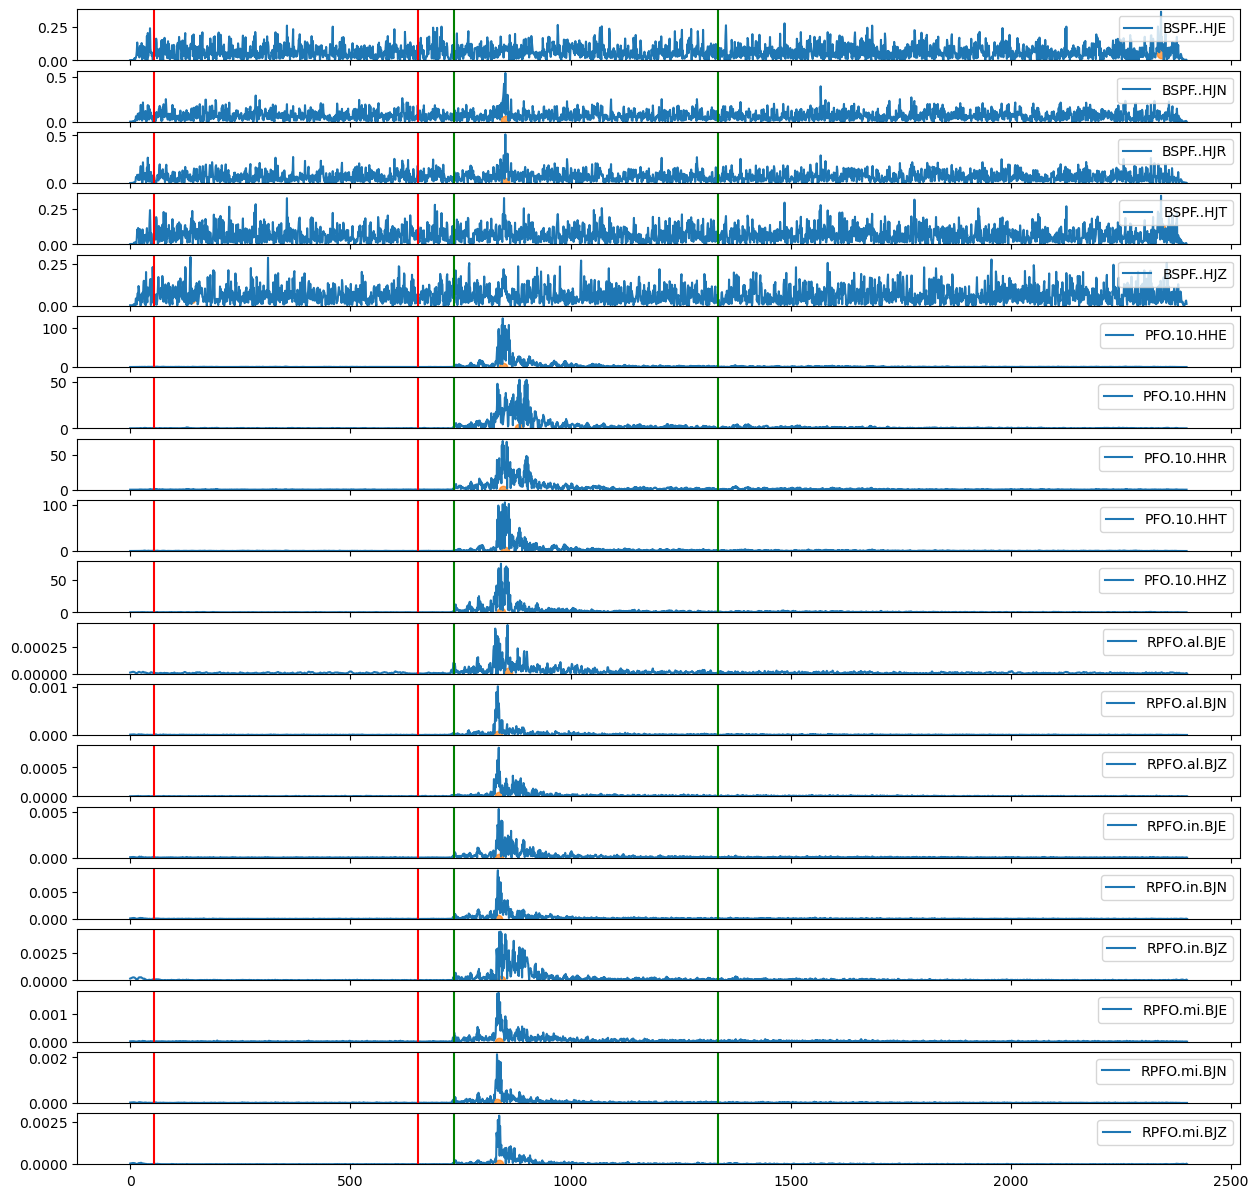

In [26]:

## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["Mag_type"] = events.type
out_df["BAZ"] = events.backazimuth
out_df["Edistance_km"] = events.distances_km
out_df["Hdistance_km"] = events.Hdistance_km

tmp_events = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_snr, data_adr, skipped, nan_row = [], [], [], 0, 0

## pre-define header for data frames
header = ['BSPF__E','BSPF__N','BSPF__R','BSPF__T','BSPF__Z',
          'PFO_10_E','PFO_10_N','PFO_10_R','PFO_10_T','PFO_10_Z',
          'RPFO_al_E','RPFO_al_N','RPFO_al_Z',
          'RPFO_in_E','RPFO_in_N','RPFO_in_Z',
          'RPFO_mi_E','RPFO_mi_N','RPFO_mi_Z'
         ]

## prepare dataframes
header_amax = [h+"_amax" for h in header]
header_amax.insert(0,"origin")
df_amax = pd.DataFrame(columns=header_amax)

header_snr = [h+"_snr" for h in header]
header_snr.insert(0,"origin")
df_snr = pd.DataFrame(columns=header_snr)


header_adr = []
for hh in ["BSPF_a_N_adr", "BSPF_a_E_adr", "BSPF_a_Z_adr", "BSPF_a_T_adr", "BSPF_a_R_adr",
           "BSPF_m_N_adr", "BSPF_m_E_adr", "BSPF_m_Z_adr", "BSPF_m_T_adr", "BSPF_m_R_adr",
           "BSPF_i_N_adr", "BSPF_i_E_adr", "BSPF_i_Z_adr", "BSPF_i_T_adr", "BSPF_i_R_adr",
           "RPFO_in_N_adr", "RPFO_in_E_adr", "RPFO_in_Z_adr",
           "RPFO_al_N_adr", "RPFO_al_E_adr", "RPFO_al_Z_adr",
           "RPFO_mi_N_adr", "RPFO_mi_E_adr", "RPFO_mi_Z_adr"]:
    header_adr.append(hh)

# header_adr = [h+"_adr" for h in header]
header_adr.insert(0,"origin")
df_adr = pd.DataFrame(columns=header_adr)



for event in tqdm(config['mseed_files'][200:201]):

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"


    if otime not in tmp_events:
        skipped += 1
        continue
    else:
        jj = tmp_events.index(otime)

#     print(f"\n -> {jj} {events.origin[jj]} ")

    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    try:
        st = obs.read(config['path_to_mseed']+event)

        st = st.resample(40)

        for tr in st:
            if "PFOIX" in tr.stats.station:
                tr.stats.station = "PFO"
                tr.stats.location = "10"


        ## add radial and transverse channels
        st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
        st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])

        if len(st) != 19:
            print(f"{len(st)} is not 19")

        ## processing data stream
        st = st.detrend("linear")
        st = st.taper(0.01)
        st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)

        # ## compute maximal amplitude values (PGA and PGR)
        # data_amax = __compute_Amax(header, st, data_amax, events.trigger_time[jj], win_length_sec=15)
        # row = {**{"origin":events.origin[jj]}, **data_amax}
        # df_amax.loc[len(df_amax)] = row

        ## compute signal-to-noise ratios
        data_snr = __compute_SNR(header, st, data_snr, events.trigger_time[jj], win_length_sec=15, plot=True, plot_save=False)
        row = {**{"origin":events.origin[jj]}, **data_snr}
        df_snr.loc[len(df_snr)] = row

        # ## compute signal-to-noise ratios
        # data_adr = __compute_adr_max(header, st, data_adr, events.trigger_time[jj], win_length_sec=15)
        # row = {**{"origin":events.origin[jj]}, **data_adr}
        # df_adr.loc[len(df_adr)] = row

    except Exception as e:
        print(e)
        print(f" -> failed for {event}")
        skipped += 1
        continue


## CC for f-bands

In [15]:
# def __cc_in_octaves(st_in, fmin, fmax):

#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     ## _____________________

# #     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
# #     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

#     df_out = DataFrame()
    
#     for comp in ["Z","N","E"]:

#         print(comp)

#         plt.figure(figsize=(15,5))

#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
#         ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
#         df_out[f'{comp}_in_fband'] = ff
#         df_out[f'{comp}_in_cc_t'] = cc_t_max
#         df_out[f'{comp}_in_cc_f'] = cc_f_max
        
#         plt.scatter(ff, cc_t_max, color="r")
#         plt.scatter(ff, cc_f_max, color="r")

#         ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

#         df_out[f'{comp}_al_fband'] = ff
#         df_out[f'{comp}_al_cc_t'] = cc_t_max
#         df_out[f'{comp}_al_cc_f'] = cc_f_max
        
#         plt.scatter(ff, cc_t_max)
#         plt.scatter(ff, cc_f_max) 

#     #     plt.xscale("log")
#         plt.show()
        
#     return df_out

In [16]:
# def __coherence_in_octaves(st_in, fmin, fmax):

#     from numpy import arange, mean
#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from scipy.signal import coherence
    
#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     ## _____________________

# #     ddf = 3
# #     fcenter = arange(fmin+ddf, fmax-ddf, 1)
# #     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
#     df_out = DataFrame()
    
#     fig, ax = plt.subplots(1,3,figsize=(15,5))
    
#     for ii, comp in enumerate(["Z","N","E"]):

#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
#         co2, co3 = [],[]
#         for (fl, fu) in fbands:
#             s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()
            
#             s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
#             s1 = s1.normalize()
#             s2 = s2.normalize()
#             s3 = s3.normalize()

#             s1 = s1.taper(0.1)
#             s2 = s2.taper(0.1)
#             s3 = s3.taper(0.1)
            
#             df = s1.stats.sampling_rate
#             tseg = 1/fl*20
#             nseg = int(df*tseg)
            
# #             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
# #             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
#             for i in range(len(ff2)):
#                 if ff2[i] < fl or ff2[i] > fu:
#                     coh2[i], coh3[i] = 0, 0
        
# #             plt.figure()
# #             plt.plot(ff2, coh2)
# #             plt.show()
            
#             co2.append(max(coh2))
#             co3.append(max(coh3))
            
#         df_out[f'{comp}_in_fc'] = fcenter
#         df_out[f'{comp}_in_co']  = co2
#         df_out[f'{comp}_al_fc'] = fcenter
#         df_out[f'{comp}_al_co']  = co3
                 
#         ax[ii].scatter(fcenter, co2, s=50, label="BSPF-RPFO_inner")
#         ax[ii].plot(fcenter, co2, ls="-")

#         ax[ii].scatter(fcenter, co3, s=50, label="BSPF-PRFO_all")
#         ax[ii].plot(fcenter, co3, ls="-")

#         ax[ii].set_title(f"max. coherence {comp}")
#         ax[ii].legend()
#         ax[ii].set_xscale("log")
#         ax[ii].grid(ls="--",zorder=0,alpha=.5, which="both")
#     plt.show();
        
#     return df_out

## Manual Selection

In [17]:
date = obs.UTCDateTime("2023-05-20")
events[(events.origin < str((date+86500).date)) & (events.origin > str((date).date))]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
211,2023-05-20 08:18:16.240,33.382167,-116.906667,12640.0,3.38,ml,19988296.24,2023-05-20T08:18:24.570000Z,2023-05-20T08:18:16.240000Z,2023-05-20T08:18:16.240000Z,6.0,238.977903,48.993538,50.597790
212,2023-05-20 08:20:51.820,33.381833,-116.904000,13440.0,2.61,ml,19988451.82,2023-05-20T08:21:00.140000Z,2023-05-20T08:20:51.820000Z,2023-05-20T08:20:51.820000Z,6.0,238.789573,48.800911,50.617808


In [18]:
good_events = [
    "2022-10-03 16:08:09.970",
    "2022-10-07 22:45:05.470",
    "2022-10-15 05:17:34.150",
    "2022-10-23 09:24:58.150",
    "2022-10-26 08:14:35.080",
    "2022-12-31 12:12:26.650",
    "2023-01-09 19:42:56.460",
    "2023-01-11 18:59:20.030",
    "2023-01-15 09:58:54.070",
    "2023-02-01 09:05:02.320",
    "2023-03-01 22:49:03.580",
    "2023-03-24 13:45:13.700",
    "2023-04-10 14:51:00.950",
    "2023-04-17 18:52:36.930",
    "2023-04-26 06:46:58.450",
    "2023-05-03 21:14:20.210",
    "2023-05-20 08:18:16.240",
]

df = pd.DataFrame()
df['origin_time'] = good_events
# df.to_pickle(config['outpath_data']+"event_selection_good.pkl")

In [19]:
from obspy import UTCDateTime

## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690", 
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

no_event_utc = list(map(UTCDateTime, no_event))


df = pd.DataFrame()
df['origin_time'] = no_event
# df.to_pickle(config['outpath_data']+"event_selection_reject.pkl")